In [177]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [178]:
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV


In [179]:
train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')


In [180]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [181]:
train.shape

(891, 12)

In [182]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: xlabel='Age', ylabel='Density'>

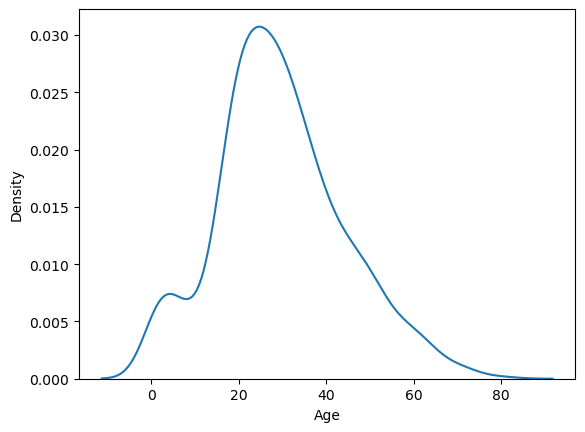

In [183]:
sns.kdeplot(train['Age'])

the age distribution is approximately normal so we will replace the mean values by median or we can use knn imputer to do so.

<Axes: xlabel='Age', ylabel='Density'>

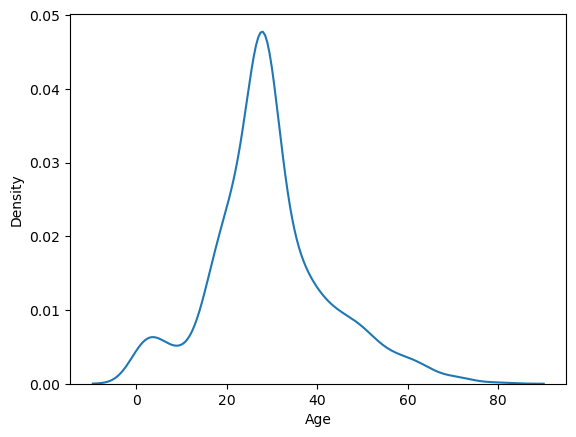

In [184]:
sns.kdeplot(train['Age'].fillna(train['Age'].median()))

<Axes: ylabel='Density'>

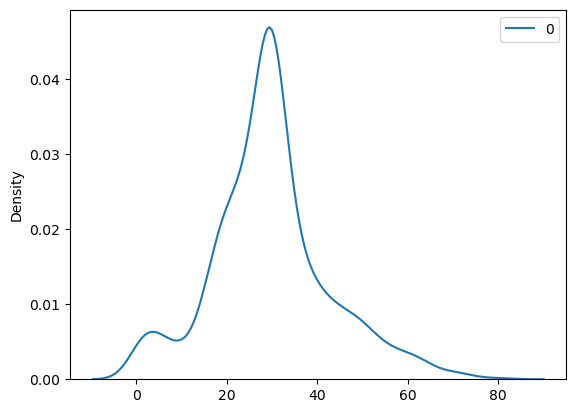

In [185]:
imputer = KNNImputer(n_neighbors=2)
sns.kdeplot(imputer.fit_transform(np.array(train['Age']).reshape(-1,1)))


there is no much difference in knn imputation and median imputation so we can choose either of these two.

In [186]:
train['Age']=train['Age'].fillna(train['Age'].median())

In [187]:
dropcol={'PassengerId','Name','Ticket','Cabin'}
#these features have no impact on the survived target variable
train=train.drop(columns=dropcol,axis=1)

In [188]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

for categorical imputation we will choose the most frequent category to replace nan values .

In [189]:
train['Embarked']=train['Embarked'].fillna('S')

In [190]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [191]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [192]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

we will encoding the categorical variable.

In [193]:
mapp={'male':1,'female':2}
mape={'S':1,'C':2,'Q':3}
train['Sex']=train['Sex'].map(mapp)
train['Embarked']=train['Embarked'].map(mape)

split the data into independent and dependent variables.

In [194]:
x=train.drop(columns='Survived',axis=1)
y=train['Survived']

In [195]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.35,random_state=42)

we will scale down the features because the Fare figure is highest .

In [196]:
sc=StandardScaler()
x_train_res=pd.DataFrame(sc.fit_transform(x_train),columns=x.columns)

In [197]:
x_test_res=pd.DataFrame(sc.transform(x_test),columns=x.columns)

In [198]:
lr=LogisticRegression()
lr.fit(x_train_res,y_train)

LogisticRegression()

In [199]:
from sklearn.metrics import classification_report,accuracy_score

In [200]:
pred=lr.predict(x_test_res)
print(confusion_matrix(pred,y_test))
print(classification_report(pred,y_test))

[[164  36]
 [ 24  88]]
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       200
           1       0.71      0.79      0.75       112

    accuracy                           0.81       312
   macro avg       0.79      0.80      0.80       312
weighted avg       0.81      0.81      0.81       312



In [201]:
acc={}
svm=SVC()
knn=KNeighborsClassifier()
rf=RandomForestClassifier()
boost=xgboost.XGBClassifier()
models=[svm,knn,rf,boost]
for i in models:
    i.fit(x_train_res,y_train)
    acc[i]=accuracy_score(y_test,i.predict(x_test_res))

    

with default model values the support vector classifier gives the highest accuracy.we now done hyperparameter tuning on randomforestclassifier model using Randomized search cv

In [202]:
params={'n_estimators':[100,150,200,250,300],
       'max_depth':[5,6,7],
        'criterion':['gini','entropy','log_loss'],
        'random_state':[0,42]
        ,'ccp_alpha':[0,0.1,0.2]}
random_search=RandomizedSearchCV(rf,param_distributions=params,cv=5,n_iter=80,n_jobs=-1,verbose=3,scoring='roc_auc')
#random_search.fit(x_train_res,y_train)

In [203]:
#random_search.best_estimator_

In [204]:
rfmodel=RandomForestClassifier(ccp_alpha=0, max_depth=5, n_estimators=150,
                       random_state=0)
rfmodel.fit(x_train_res,y_train)

RandomForestClassifier(ccp_alpha=0, max_depth=5, n_estimators=150,
                       random_state=0)

In [205]:
accuracy_score(y_test,rfmodel.predict(x_test_res))

0.8237179487179487

In [206]:
params2={'eta':[0.1,0.15,0.2,0.25,0.3],
         'max_depth':[4,5,6,7,8],
         'gamma':[0.1,0.2,0.3],
         'subsample':[0.5,0.6,0.7,0.8,0.9,1],
         'colsample_bytree':[0.5,0.6,0.7,0.8],
         'lambda':[1,2,3,4],
         'alpha':[0,1,2,4],
         'seed':[0,2,4,6],
         'n_estimators':[100,150,200,250]
}
xgtuned=RandomizedSearchCV(boost,param_distributions=params2,scoring='roc_auc',cv=5,n_iter=100,verbose=3,n_jobs=-1)
#xgtuned.fit(x_train_res,y_train)

In [207]:
#xgtuned.best_estimator_

In [208]:
boosttuned=xgboost.XGBClassifier(alpha=2,n_estimators=250,colsample_bytree=0.6,eta=0.3,gamma=0.2,max_depth=7)
boosttuned.fit(x_train_res,y_train)

XGBClassifier(alpha=2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=0.2, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, ...)

In [209]:
accuracy_score(y_test,boosttuned.predict(x_test_res))

0.8333333333333334

###### 

# our model is ready ..

In [210]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [211]:
dropcol

{'Cabin', 'Name', 'PassengerId', 'Ticket'}

In [212]:
test=test.drop(columns=dropcol,axis=1)

In [213]:
test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

<Axes: xlabel='Age', ylabel='Density'>

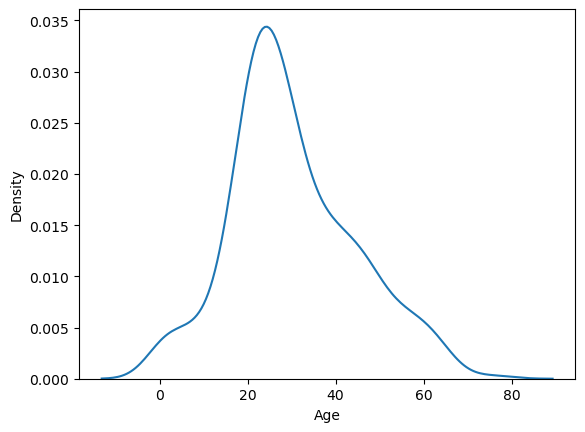

In [214]:
sns.kdeplot(test['Age'])

In [215]:
s=(imputer.fit_transform(np.array(test['Age']).reshape(-1,1)))
test['Age']=s

<Axes: xlabel='Fare', ylabel='Density'>

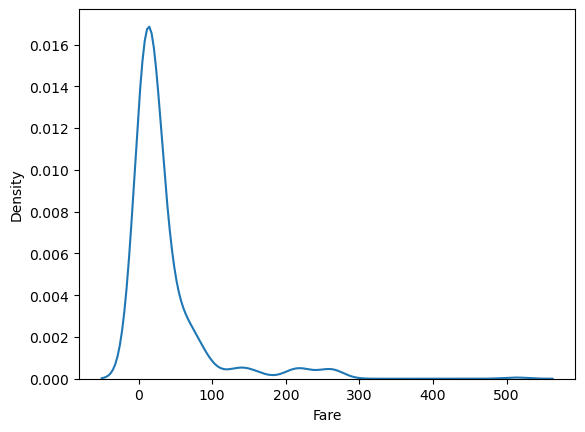

In [216]:
sns.kdeplot(test['Fare'])

In [217]:
test['Fare']=test['Fare'].fillna(test['Fare'].median())

In [218]:
mapp,mape

({'male': 1, 'female': 2}, {'S': 1, 'C': 2, 'Q': 3})

In [219]:
test['Sex']=test['Sex'].map(mapp)
test['Embarked']=test['Embarked'].map(mape)

In [220]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.50000,0,0,7.8292,3
1,3,2,47.00000,1,0,7.0000,1
2,2,1,62.00000,0,0,9.6875,3
3,3,1,27.00000,0,0,8.6625,1
4,3,2,22.00000,1,1,12.2875,1
...,...,...,...,...,...,...,...
413,3,1,30.27259,0,0,8.0500,1
414,1,2,39.00000,0,0,108.9000,2
415,3,1,38.50000,0,0,7.2500,1
416,3,1,30.27259,0,0,8.0500,1


In [221]:
test_res=pd.DataFrame(sc.fit_transform(test),columns=test.columns)

In [222]:
pred=boosttuned.predict(test_res)

In [223]:
subm=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
subm

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [224]:
sub=pd.DataFrame({'Survived':pred},index=subm.PassengerId)

sub.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [225]:
sub.to_csv('submission.csv')

[CV 3/5] END alpha=1, colsample_bytree=0.6, eta=0.2, gamma=0.2, lambda=3, max_depth=5, n_estimators=100, seed=6, subsample=1;, score=0.770 total time=   0.1s
[CV 4/5] END alpha=1, colsample_bytree=0.6, eta=0.2, gamma=0.2, lambda=3, max_depth=5, n_estimators=100, seed=6, subsample=1;, score=0.874 total time=   0.1s
[CV 5/5] END alpha=1, colsample_bytree=0.6, eta=0.2, gamma=0.2, lambda=3, max_depth=5, n_estimators=100, seed=6, subsample=1;, score=0.881 total time=   0.1s
[CV 2/5] END alpha=0, colsample_bytree=0.6, eta=0.3, gamma=0.3, lambda=1, max_depth=6, n_estimators=150, seed=0, subsample=0.9;, score=0.898 total time=   0.2s
[CV 3/5] END alpha=0, colsample_bytree=0.6, eta=0.3, gamma=0.3, lambda=1, max_depth=6, n_estimators=150, seed=0, subsample=0.9;, score=0.777 total time=   0.2s
[CV 5/5] END alpha=0, colsample_bytree=0.6, eta=0.3, gamma=0.3, lambda=1, max_depth=6, n_estimators=150, seed=0, subsample=0.9;, score=0.825 total time=   0.1s
[CV 2/5] END alpha=4, colsample_bytree=0.8, et